In [39]:
# Standard library imports
import os
import sys

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
os.chdir('..')
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
src_path = os.path.join(project_root, 'src')
sys.path.append(project_root)
sys.path.append(src_path)


In [47]:
# Local modules imports
from helper_functions import (
    load_data_spi,
    load_pickle,
)
from estimation.covariance import Covariance, CovarianceSpecification

from estimation.expected_return import ExpectedReturn

from optimization.optimization import (
    BlackLitterman, ScoreVariance, MeanVariance , MaxSharpe, BlackLittermanMS                            
)
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    # Selection item builder functions
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_selection_ltr,
    # Optimization item builder functions
    bibfn_return_series,
    bibfn_scores_ltr,
    bibfn_equal_weights,
    # Constraints item builder functions
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
    bibfn_sector_exposure_constraints
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [48]:
# --------------------------------------------------------------------------
# Load data
# - market data (from parquet file)
# - jkp data (from parquet file)
# - swiss performance index, SPI (from csv file)
# --------------------------------------------------------------------------

path_to_data = "C:/Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy/data/"

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')
jkp_data = pd.read_parquet(path = f'{path_to_data}jkp_data.parquet')

# Instantiate the BacktestData class and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.jkp_data = jkp_data
data.bm_series = load_data_spi(path=path_to_data)

In [42]:
# --------------------------------------------------------------------------
# Create a features dataframe from the jkp_data
# Reset the date index to be consistent with the date index in market_data
# --------------------------------------------------------------------------

market_data_dates = data.market_data.index.get_level_values('date').unique().sort_values()
jkp_data_dates = data.jkp_data.index.get_level_values('date').unique().sort_values()

# Find the nearest future market_data_date for each jkp_data_date
dates_map = {
    date: min(market_data_dates[market_data_dates > date])
    for date in jkp_data_dates
}

# Generates a features dataframe from the jkp_data where you reset
# the date index to b
features = data.jkp_data.reset_index()
features['date'] = features['date'].map(dates_map)
features = features.set_index(['date', 'id'])

In [43]:
# --------------------------------------------------------------------------
# Define training dates and rebalancing dates
# --------------------------------------------------------------------------

train_dates = features.index.get_level_values('date').unique().sort_values()
train_dates = train_dates[train_dates > market_data_dates[0]]

train_dates =train_dates[::3]

rebdates = train_dates[train_dates >= '2015-01-01'].strftime('%Y-%m-%d').tolist()
rebdates = rebdates[0:-1]

Changed rebalance dates to every 3 months instead of every month

In [44]:
# --------------------------------------------------------------------------
# Prepare labels (i.e., ranks of period returns)
# --------------------------------------------------------------------------

# Load return series
return_series = data.get_return_series()

# Compute period returns between the training dates
return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()

# Shift the labels by -1 period (as we want to predict next period return ranks)
return_series_agg_shift = return_series_agg.shift(-1)
# return_series_agg_shift = return_series_agg   # ~~~~~~~~~~~~~~~~~~~~~~~~

# Stack the returns (from wide to long format)
ret = return_series_agg_shift.unstack().reorder_levels([1, 0]).dropna()
ret.name = 'ret'
ret

# Merge the returns and the features dataframes
merged_df = ret.to_frame().join(features, how='inner').sort_index()
merged_df

# Generate the labels (ranks) for the merged data
labels = merged_df.groupby('date')['ret'].rank(method='first', ascending=True).astype(int)
labels = 100 * labels / merged_df.groupby('date').size() # Normalize the ranks to be between 0 and 100
labels = labels.astype(int)  # Convert to integer type
labels

# Insert the labels into the merged data frame
merged_df.insert(0, 'label', labels)
merged_df

# Reset the index of the merged data frame
merged_df.reset_index(inplace=True)
merged_df

# Add the merged data frame to the BacktestData object
data.merged_df = merged_df

C:\Users\angus\AppData\Local\Temp\ipykernel_8668\3127731825.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()


In [45]:
# --------------------------------------------------------------------------
# Prepare backtest service
# --------------------------------------------------------------------------

# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
    'ltr': SelectionItemBuilder(
        bibfn = bibfn_selection_ltr,
    ),
    #'jkp_factor_scores': SelectionItemBuilder(
    #    bibfn = bibfn_filter_jkp_factor_scores,
    #    bounds ={ 
    #'ret_6_1': [0.01, 1.0],   
    #'rvol_21d': [0.0, 0.95],  

    # more moderate value/quality cushions (quantiles)

    #'be_me':   [0.0, 0.95],  
    #'f_score': [0.05, 1.0], 
    # 
    # 
    #'qmj': [0.01, 1.0]
    #   },
    #),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series, # Data used for covariance estimation
        width = 252*3,
        fill_value = 0,
    ),
    'cap_weights': OptimizationItemBuilder(        # NEW!
        bibfn = bibfn_equal_weights,
    ),

    'scores_ltr': OptimizationItemBuilder(
        bibfn = bibfn_scores_ltr,
        params_xgb = {
            'objective': 'rank:pairwise',
            # 'objective': 'rank:ndcg',
            # 'ndcg_exp_gain': False,
            # 'eval_metric': 'ndcg@10',
            'min_child_weight': 1,
            'max_depth': 6,
            'eta': 0.1,
            'gamma': 1.0,
            'lambda': 1,
            'alpha': 0,
        },
        # training_dates = train_dates[train_dates <= rebdates[0]],  # Only train on the first rebalancing
        training_dates = train_dates,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1.2,
        sense = '<='
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
        lower= 0,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.10},
    ),
    'sector_exposure_constraints': OptimizationItemBuilder(
        bibfn = bibfn_sector_exposure_constraints,
        default_limit = 0.15
        )

    }

risk_aversion = 100
turnover_penalty = 0.01
cov_spec = Covariance(CovarianceSpecification(method='ewma_ledoit_mix', span1=126, span2=3*256,
                                               short_weight=0.3, long_weight=0.7 , clip = [-0.05, 0.05]))
solver_name='cvxopt'

opt1 = BlackLitterman(
        solver_name=solver_name,
        covariance=cov_spec,
        risk_aversion=risk_aversion,
        tau_psi=0.1,
        tau_omega=0.1,
        #view_method='quintile',
        view_method='absolute',
        fields=['scores'],
        turnover_penalty = turnover_penalty
    )

opt2 = ScoreVariance(
        field = 'scores',
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt3 = MeanVariance(
        expected_return = ExpectedReturn(method = 'geometric'),
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt4 = MaxSharpe(
        expected_return = ExpectedReturn(method = 'geometric'),
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt5 = BlackLittermanMS(
        solver_name=solver_name,
        covariance=cov_spec,
        risk_aversion=risk_aversion,
        tau_psi=0.1,
        tau_omega=0.0001,
        #view_method='quintile',
        view_method='absolute',
        fields=['scores'],
        turnover_penalty = turnover_penalty
    )

# Initialize the backtest service
bs = BacktestService(
    data = data,
    optimization=opt3,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

Added in size_dep_upper_bounds and sector_exposure_constraints, increased budget constraint to 1.2 with sense <=, and changed box constraints to lower = 0 and upper = 0.1. (EXPLAIN WHY).

Also then tested 5 different optimisation techniques and found Mean Variance to work the best. (Expand on this a lot, maybe showing plots to compare how the 5 methods performed).

In [46]:
# --------------------------------------------------------------------------
# Run backtests
# --------------------------------------------------------------------------

bt_bl_ltr = Backtest()
bt_bl_ltr.run(bs=bs)
    
path = "C:/Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy/BACKTESTS/"  # <change this to your path where you want to store the backtest>
filename = 'backtest_bl_ltr.pickle' # <change this to your desired filename>

# # Save the backtest as a .pickle file
bt_bl_ltr.save(
     path = path, 
     filename = filename 
)

Rebalancing date: 2015-01-01
Covariance estimation method: ewma_ledoit_mix


RuntimeError: Estimation method not recognized.

c:\Users\angus\OneDrive\Desktop\QPMwP\Investment_Strategy//src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Users\angus\OneDrive\Desktop\QPMwP\Investment_Strategy//src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Outperformance vs Benchmark'}>

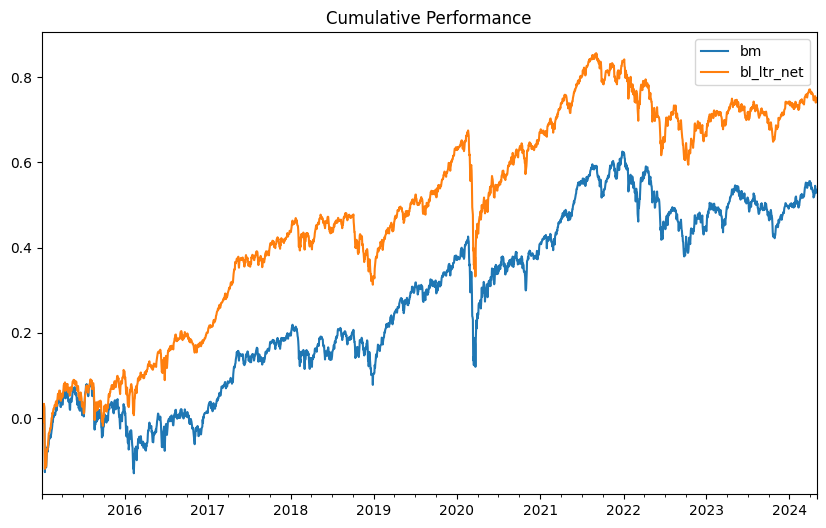

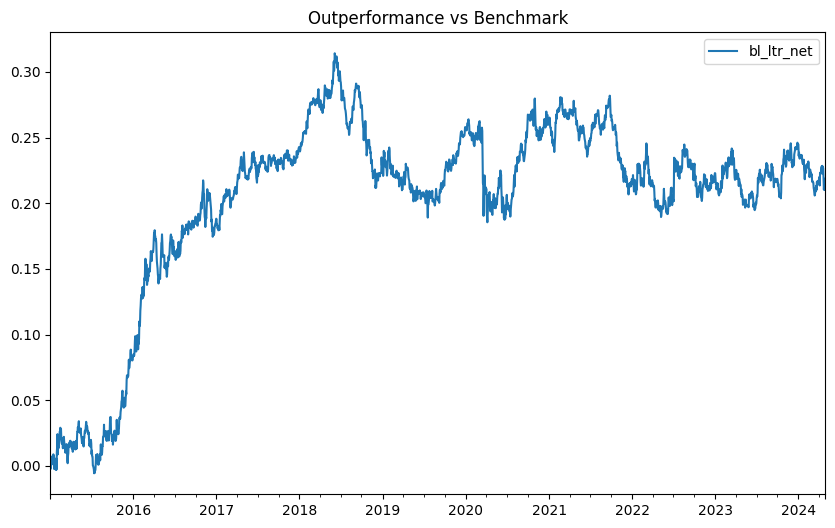

In [29]:
# --------------------------------------------------------------------------
# Simulate strategies
# --------------------------------------------------------------------------

bt_bl_ltr = load_pickle(
    filename = 'backtest_bl_ltr.pickle',
    path = path,
)

#bt_sv_retrain_monthly = load_pickle(
#    filename = 'backtest_sv_retrain_monthly.pickle',
#    path = path,
#)

fixed_costs = 0
variable_costs = 0.002
return_series = bs.data.get_return_series()

strategy_dict = {
    'bl_ltr': bt_bl_ltr.strategy,
#    'sv_retrain_monthly': bt_sv_retrain_monthly.strategy,
}

sim_dict_gross = {
    f'{key}_gross': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=0,
    )
    for key, value in strategy_dict.items()
}
sim_dict_net = {
    f'{key}_net': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    )
    for key, value in strategy_dict.items()
}

# Flag: when True, scale the benchmark returns by the Net Exposure, to make the comparison fairer

# 1) fetch weights and calculate exposures
bm_weights_scale = False

# 1) fetch weights and calculate exposures
wts = bt_bl_ltr.strategy.get_weights_df()

# ensure the index is real datetime, not strings
wts.index    = pd.to_datetime(wts.index)

net_exposure = wts.sum(axis=1)
gross_exposure = wts.abs().sum(axis=1)
net_exposure.name   = "Net Exposure"
gross_exposure.name = "Gross Exposure"

# 2) build sim DataFrame with unscaled bm
sim = pd.concat({
    'bm': bs.data.bm_series,
    **sim_dict_net,
}, axis=1)

# 3) optionally scale bm in-place
if bm_weights_scale:
    # align net_exposure to sim’s index, fill any edge NaNs
    ne = net_exposure.reindex(sim.index).fillna(method='ffill').fillna(method='bfill')
    for col in sim.columns:
        sim[col] = sim[col] * ne

# 4) drop any remaining NaNs and plot
sim = sim.dropna()
#sim = sim.iloc[1:]  

cumulative_returns = np.log(1 + sim).cumsum()
cumulative_returns.plot(title='Cumulative Performance', figsize=(10, 6))

outperformance = cumulative_returns.subtract(cumulative_returns['bm'], axis=0)
outperformance.drop(columns=['bm'], errors='ignore').plot(
    title='Outperformance vs Benchmark', figsize=(10, 6)
)

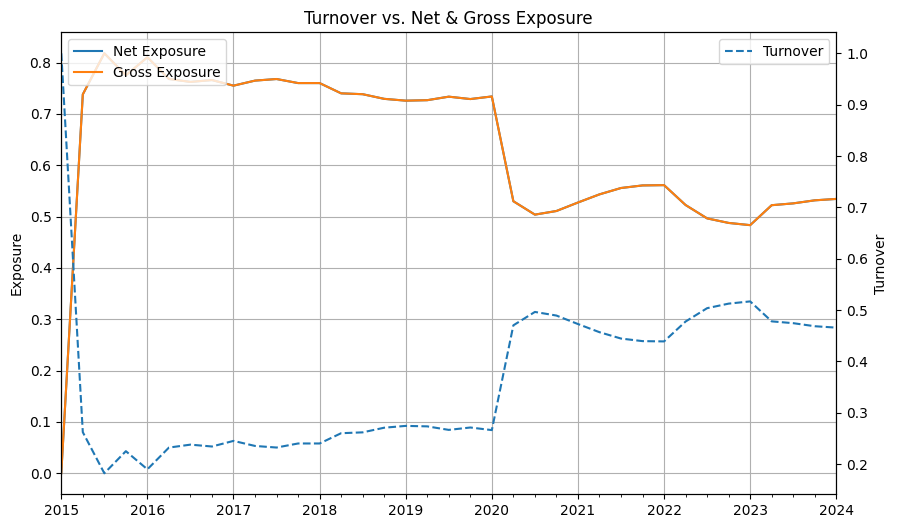

In [30]:
# --------------------------------------------------------------------------
# Turnover
# --------------------------------------------------------------------------

# existing turnover & weights
to_bl_ltr = bt_bl_ltr.strategy.turnover(return_series=return_series)
to_bl_ltr.index    = pd.to_datetime(to_bl_ltr.index)

# name turnover
to_bl_ltr.name = "Turnover"

# combine into one DataFrame
df = pd.concat([to_bl_ltr, net_exposure, gross_exposure], axis=1).dropna()

# plot Net & Gross Exposure on primary axis, Turnover on secondary
ax = df[["Net Exposure","Gross Exposure"]].plot(title="Turnover vs. Net & Gross Exposure", figsize=(10,6))
ax.set_ylabel("Exposure")
ax.grid(True)

ax2 = ax.twinx()
df["Turnover"].plot(ax=ax2, linestyle="--", label="Turnover")
ax2.set_ylabel("Turnover")
ax2.legend(loc="upper right")

# show legend for exposures
ax.legend(loc="upper left")

In [ ]:
# --------------------------------------------------------------------------
# Decriptive statistics
# --------------------------------------------------------------------------

# Alternative implementation without empyrical

# Helper functions for performance metrics
def annual_return(series, periods_per_year=252):
    return (1 + series.mean()) ** periods_per_year - 1

def cumulative_returns(series):
    return (1 + series).prod() - 1

def annual_volatility(series, periods_per_year=252):
    return series.std() * np.sqrt(periods_per_year)

def sharpe_ratio(series, risk_free_rate=0, periods_per_year=252):
    excess_return = series - risk_free_rate / periods_per_year
    return excess_return.mean() / series.std() * np.sqrt(periods_per_year)

def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    return drawdown.min()


def tracking_error(series, benchmark):
    return (series - benchmark).std() * np.sqrt(252)

def downside_tracking_error(series, benchmark):
    active     = series - benchmark
    neg_active = active[active < 0]
    return np.sqrt(np.mean(neg_active**2)) * np.sqrt(252)

def information_ratio(series, benchmark):
    active = series - benchmark
    # annualized active return / annualized tracking error
    return (active.mean() * 252) / (active.std() * np.sqrt(252))


def capture_ratios(r_p: pd.Series, r_b: pd.Series) -> tuple[float,float]:
    """
    Calculate upside and downside capture of portfolio returns r_p vs. benchmark r_b.
    Returns (upside_capture, downside_capture).
    """
    up_ix   = r_b > 0
    down_ix = r_b < 0

    avg_p_up   = r_p[ up_ix].mean()
    avg_b_up   = r_b[ up_ix].mean()
    avg_p_down = r_p[down_ix].mean()
    avg_b_down = r_b[down_ix].mean()

    up_cap   = avg_p_up   / avg_b_up   if avg_b_up   else np.nan
    down_cap = avg_p_down / avg_b_down if avg_b_down else np.nan
    return up_cap, down_cap

# Helper function for hit ratio
def hit_ratio(series, benchmark):
    """
    Calculate the hit ratio: percentage of periods where the strategy outperforms the benchmark.
    """
    return (series > benchmark).mean()

# Compute individual performance metrics for each simulated strategy
annual_return_dict        = {}
cumulative_returns_dict   = {}
annual_volatility_dict    = {}
sharpe_ratio_dict         = {}
max_drawdown_dict         = {}
tracking_error_dict       = {}
downside_te_dict          = {}
information_ratio_dict    = {}
hit_ratio_dict            = {}  # New dictionary for hit ratio
up_capture_dict           = {}
down_capture_dict         = {}

for column in sim.columns:
    print(f'Performance metrics for {column}')
    # existing metrics
    annual_return_dict[column]      = annual_return(sim[column])
    cumulative_returns_dict[column] = cumulative_returns(sim[column])
    annual_volatility_dict[column]  = annual_volatility(sim[column])
    sharpe_ratio_dict[column]       = sharpe_ratio(sim[column])
    max_drawdown_dict[column]       = max_drawdown(sim[column])
    tracking_error_dict[column]     = tracking_error(sim[column], sim['bm'])
    downside_te_dict[column]        = downside_tracking_error(sim[column], sim['bm'])
    information_ratio_dict[column]  = information_ratio(sim[column], sim['bm'])
    hit_ratio_dict[column]          = hit_ratio(sim[column], sim['bm'])  # Calculate hit ratio
    
    # up/down capture (skip benchmark itself)
    if column != 'bm':
        up_cap, down_cap = capture_ratios(sim[column], sim['bm'])
        up_capture_dict[column]   = up_cap
        down_capture_dict[column] = down_cap

# Combine results into DataFrames
annual_returns     = pd.DataFrame(annual_return_dict,      index=['Annual Return'])
cumret             = pd.DataFrame(cumulative_returns_dict, index=['Cumulative Return'])
annual_volatility  = pd.DataFrame(annual_volatility_dict,  index=['Annual Volatility'])
sharpe             = pd.DataFrame(sharpe_ratio_dict,       index=['Sharpe Ratio'])
mdd                = pd.DataFrame(max_drawdown_dict,       index=['Max Drawdown'])
tracking_error     = pd.DataFrame(tracking_error_dict,     index=['Tracking Error'])
downside_te        = pd.DataFrame(downside_te_dict,        index=['Downside Tracking Error'])
info_ratio         = pd.DataFrame(information_ratio_dict,  index=['Information Ratio'])
hit_ratio_df       = pd.DataFrame(hit_ratio_dict,          index=['Hit Ratio'])  # New DataFrame for hit ratio
up_capture         = pd.DataFrame(up_capture_dict,         index=['Upside Capture'])
down_capture       = pd.DataFrame(down_capture_dict,       index=['Downside Capture'])

# Concatenate all metrics into a single DataFrame
performance_metrics = pd.concat([
    annual_returns,
    cumret,
    annual_volatility,
    sharpe,
    mdd,
    tracking_error,
    downside_te,
    info_ratio,
    hit_ratio_df,  # Add hit ratio here
    up_capture,
    down_capture
])

performance_metrics

Performance metrics for bm
Performance metrics for bl_ltr_net


C:\Users\angus\AppData\Local\Temp\ipykernel_8668\1296587809.py:38: RuntimeWarning: invalid value encountered in scalar divide
  return (active.mean() * 252) / (active.std() * np.sqrt(252))


,bm,bl_ltr_net
Annual Return,0.067898,0.089986
Cumulative Return,0.701100,1.116910
Annual Volatility,0.145660,0.129918
Sharpe Ratio,0.451055,0.663339
Max Drawdown,-0.263289,-0.289914
Tracking Error,0.000000,0.062023
Downside Tracking Error,NaN,0.062857
Information Ratio,NaN,0.330180
Upside Capture,NaN,0.807692
Downside Capture,NaN,0.763766
